/tmp/ipykernel_58597/3037603739.py:54: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[TIME_COL] = pd.to_datetime(df[TIME_COL], infer_datetime_format=True, errors="coerce")


Init 1/12: RMSE=0.12115 | {'lookback': 36, 'hidden': 64, 'layers': 1, 'dropout': 0.1, 'batch': 64, 'bidir': True, 'lr': 0.0003, 'wd': 0.0001, 'clip': None, 'log_target': False, 'turb_on': True}
Init 2/12: RMSE=0.11646 | {'lookback': 24, 'hidden': 128, 'layers': 3, 'dropout': 0.0, 'batch': 256, 'bidir': True, 'lr': 0.0003, 'wd': 0.0, 'clip': 1.0, 'log_target': False, 'turb_on': False}
Init 3/12: RMSE=0.11706 | {'lookback': 36, 'hidden': 64, 'layers': 2, 'dropout': 0.1, 'batch': 64, 'bidir': False, 'lr': 0.001, 'wd': 1e-05, 'clip': None, 'log_target': False, 'turb_on': False}
Init 4/12: RMSE=0.12308 | {'lookback': 12, 'hidden': 64, 'layers': 3, 'dropout': 0.0, 'batch': 64, 'bidir': True, 'lr': 0.0001, 'wd': 0.0, 'clip': 1.0, 'log_target': False, 'turb_on': True}
Init 5/12: RMSE=0.11621 | {'lookback': 12, 'hidden': 128, 'layers': 3, 'dropout': 0.1, 'batch': 256, 'bidir': False, 'lr': 0.001, 'wd': 0.0, 'clip': 0.5, 'log_target': False, 'turb_on': False}
Init 6/12: RMSE=0.11621 | {'lookback

{'lookback': 12,
 'hidden': 128,
 'layers': 3,
 'dropout': 0.1,
 'batch': 256,
 'bidir': False,
 'lr': 0.001,
 'wd': 0.0001,
 'clip': 0.5,
 'log_target': False,
 'turb_on': False}

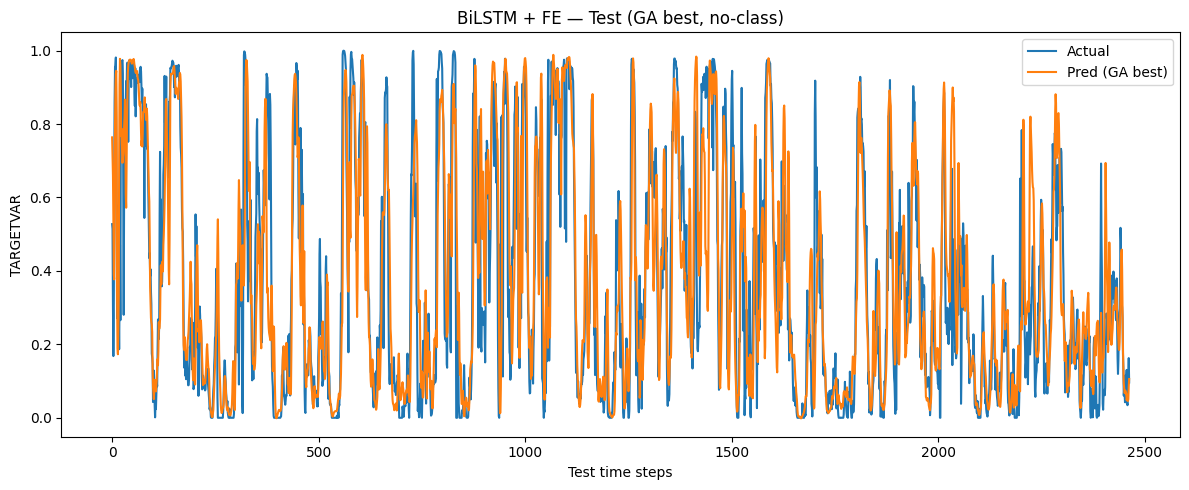

In [8]:
# ga_tune_bilstm_wind_noclass_discrete.py
import argparse, json, math, random
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import joblib
import matplotlib.pyplot as plt

# ===================== Columns & Base Features =====================
TIME_COL   = "TIMESTAMP"
TARGET_COL = "TARGETVAR"
BASE_FEATS = ["U10", "V10", "U100", "V100"]

# engineered & lag features (non-leaky)
LAGS_Y       = [1, 3, 6, 12, 24]
LAGS_SPEED   = [1, 3, 6]
ROLLS_Y      = [6, 12, 24]

# turbulence (can be toggled by GA)
TURB_WINS    = [6, 12, 24, 48]

# splits
TRAIN_RATIO  = 0.70
VAL_RATIO    = 0.15  # test ≈ 0.15

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===================== Small utils =====================
def set_seed(seed: int):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)

def smape(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    return 100.0 * np.mean(2.0 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true) + eps))

def mean_squared_error(y_true, y_pred):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    return np.mean((y_true - y_pred) ** 2)

# ===================== Data =====================
def load_data(file_path: str) -> pd.DataFrame:
    # Uses CLI-provided path. Supports Excel/CSV.
    if file_path.lower().endswith((".xlsx", ".xls")):
        df = pd.read_excel(file_path)
    else:
        df = pd.read_csv(file_path)
    df[TIME_COL] = pd.to_datetime(df[TIME_COL], infer_datetime_format=True, errors="coerce")
    df = df.sort_values(TIME_COL).reset_index(drop=True)
    return df

def add_engineered_features(df: pd.DataFrame, include_turbulence: bool) -> pd.DataFrame:
    out = df.copy()
    # wind speed & direction
    out["speed10"]  = np.sqrt(out["U10"]**2  + out["V10"]**2)
    out["speed100"] = np.sqrt(out["U100"]**2 + out["V100"]**2)
    dir10  = np.arctan2(out["V10"],  out["U10"])
    dir100 = np.arctan2(out["V100"], out["U100"])
    out["dir10_sin"], out["dir10_cos"]   = np.sin(dir10),  np.cos(dir10)
    out["dir100_sin"], out["dir100_cos"] = np.sin(dir100), np.cos(dir100)
    # shear & veer
    out["shear_speed"] = out["speed100"] - out["speed10"]
    veer = dir100 - dir10
    out["veer_sin"], out["veer_cos"] = np.sin(veer), np.cos(veer)
    # time (cyclic)
    out["hour"] = out[TIME_COL].dt.hour
    out["day"]  = out[TIME_COL].dt.dayofyear
    out["hour_sin"] = np.sin(2*np.pi*out["hour"]/24.0)
    out["hour_cos"] = np.cos(2*np.pi*out["hour"]/24.0)
    out["day_sin"]  = np.sin(2*np.pi*out["day"]/366.0)
    out["day_cos"]  = np.cos(2*np.pi*out["day"]/366.0)
    # target lags (shifted)
    for L in LAGS_Y:
        out[f"y_lag{L}"] = out[TARGET_COL].shift(L)
    # rolling means of y (shift before rolling)
    for W in ROLLS_Y:
        out[f"y_roll{W}"] = out[TARGET_COL].shift(1).rolling(W, min_periods=W).mean()
    # speed lags
    for L in LAGS_SPEED:
        out[f"speed10_lag{L}"]  = out["speed10"].shift(L)
        out[f"speed100_lag{L}"] = out["speed100"].shift(L)
    # turbulence / gustiness (shifted to avoid leakage)
    if include_turbulence:
        for W in TURB_WINS:
            s10  = out["speed10"].shift(1).rolling(W, min_periods=W)
            s100 = out["speed100"].shift(1).rolling(W, min_periods=W)
            out[f"speed10_std{W}"]  = s10.std()
            out[f"speed100_std{W}"] = s100.std()
            out[f"speed10_rng{W}"]  = s10.max() - s10.min()
            out[f"speed100_rng{W}"] = s100.max() - s100.min()
            out[f"y_std{W}"]        = out[TARGET_COL].shift(1).rolling(W, min_periods=W).std()
    return out

def build_feat_list(include_turbulence: bool):
    base = (
        BASE_FEATS +
        ["speed10","speed100","dir10_sin","dir10_cos","dir100_sin","dir100_cos",
         "shear_speed","veer_sin","veer_cos","hour_sin","hour_cos","day_sin","day_cos"] +
        [f"y_lag{L}" for L in LAGS_Y] +
        [f"y_roll{W}" for W in ROLLS_Y] +
        [f"speed10_lag{L}" for L in LAGS_SPEED] +
        [f"speed100_lag{L}" for L in LAGS_SPEED]
    )
    if not include_turbulence:
        return base
    turb = (
        [f"speed10_std{W}"  for W in TURB_WINS] +
        [f"speed100_std{W}" for W in TURB_WINS] +
        [f"speed10_rng{W}"  for W in TURB_WINS] +
        [f"speed100_rng{W}" for W in TURB_WINS] +
        [f"y_std{W}"        for W in TURB_WINS]
    )
    return base + turb

def make_sequences(X, y, lookback):
    Xs, ys = [], []
    for i in range(lookback, len(X)):
        Xs.append(X[i-lookback:i, :])
        ys.append(y[i, 0])
    return np.array(Xs, np.float32), np.array(ys, np.float32).reshape(-1,1)

def batch_iter(X, y, batch_size, shuffle):
    n = len(X)
    idx = np.arange(n)
    if shuffle:
        np.random.shuffle(idx)
    for i in range(0, n, batch_size):
        b = idx[i:i+batch_size]
        yield torch.from_numpy(X[b]).float(), torch.from_numpy(y[b]).float()

# ===================== "No-class" model components =====================
def build_components(input_size, hidden, layers, dropout, bidir):
    lstm = nn.LSTM(input_size=input_size,
                   hidden_size=hidden,
                   num_layers=layers,
                   batch_first=True,
                   dropout=dropout if layers > 1 else 0.0,
                   bidirectional=bidir).to(DEVICE)
    out_size = hidden * (2 if bidir else 1)
    norm = nn.LayerNorm(out_size).to(DEVICE)
    lin1 = nn.Linear(out_size, out_size).to(DEVICE)
    lin2 = nn.Linear(out_size, 1).to(DEVICE)
    return {"lstm": lstm, "norm": norm, "lin1": lin1, "lin2": lin2, "dropout": dropout}

def set_train_mode(mods, train: bool):
    for m in [mods["lstm"], mods["norm"], mods["lin1"], mods["lin2"]]:
        m.train(mode=train)

def forward_pass(x, mods, training: bool):
    # x: (B,T,F)
    o, _ = mods["lstm"](x)               # (B,T,H*)
    last = o[:, -1, :]                   # (B,H*)
    last = mods["norm"](last)            # (B,H*)
    last = F.gelu(mods["lin1"](last))    # (B,H*)
    last = F.dropout(last, p=mods["dropout"], training=training)
    yhat = mods["lin2"](last)            # (B,1)
    return yhat

def optimizer_for(mods, lr, weight_decay):
    params = list(mods["lstm"].parameters()) + \
             list(mods["norm"].parameters()) + \
             list(mods["lin1"].parameters()) + \
             list(mods["lin2"].parameters())
    return torch.optim.Adam(params, lr=lr, weight_decay=weight_decay)

# ===================== Fold train (Val RMSE) =====================
def train_fold(Xtr, ytr, Xva, yva, params, max_epochs, es_patience):
    # scalers on train only
    xsc = StandardScaler().fit(Xtr)
    ysc = StandardScaler().fit(ytr)
    Xtr_s, ytr_s = xsc.transform(Xtr), ysc.transform(ytr)
    Xva_s, yva_s = xsc.transform(Xva), ysc.transform(yva)

    lookback = params["lookback"]
    Xtr_seq, ytr_seq = make_sequences(Xtr_s, ytr_s, lookback)
    Xva_seq, yva_seq = make_sequences(Xva_s, yva_s, lookback)
    if len(Xtr_seq) < 16 or len(Xva_seq) < 16:
        return float("inf"), None  # degenerate

    mods = build_components(Xtr_seq.shape[-1], params["hidden"], params["layers"],
                            params["dropout"], params["bidir"])
    opt  = optimizer_for(mods, params["lr"], params["wd"])
    sched = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(opt, T_0=10, T_mult=2, eta_min=1e-5)
    loss_fn = nn.SmoothL1Loss(beta=0.5)

    def inv_target(y_scaled):
        y = ysc.inverse_transform(y_scaled).ravel()
        if params["log_target"]:
            y = np.expm1(y)
        return y

    best = float("inf"); no_improve = 0
    best_state = {k: v.state_dict() for k, v in mods.items() if isinstance(v, nn.Module)}

    for epoch in range(1, max_epochs+1):
        # train
        set_seed(epoch)  # small shake
        set_train_mode(mods, True)
        for xb, yb in batch_iter(Xtr_seq, ytr_seq, params["batch"], shuffle=True):
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            pred = forward_pass(xb, mods, training=True)
            loss = loss_fn(pred, yb)
            loss.backward()
            if params["clip"] is not None:
                nn.utils.clip_grad_norm_(
                    list(mods["lstm"].parameters()) + list(mods["lin1"].parameters()) + list(mods["lin2"].parameters()),
                    params["clip"]
                )
            opt.step()
        sched.step(epoch-1)

        # validate (RMSE in original units)
        set_train_mode(mods, False)
        preds_s, trues_s = [], []
        for xb, yb in batch_iter(Xva_seq, yva_seq, params["batch"], shuffle=False):
            with torch.no_grad():
                pr = forward_pass(xb.to(DEVICE), mods, training=False).cpu().numpy()
            preds_s.append(pr); trues_s.append(yb.numpy())
        preds_s = np.vstack(preds_s); trues_s = np.vstack(trues_s)
        y_pred = inv_target(preds_s)
        y_true = inv_target(trues_s)
        rmse = math.sqrt(mean_squared_error(y_true, y_pred))

        if rmse < best - 1e-6:
            best = rmse; no_improve = 0
            best_state = {k: v.state_dict() for k, v in mods.items() if isinstance(v, nn.Module)}
        else:
            no_improve += 1
            if no_improve >= es_patience:
                break

    return best, (best_state, Xtr_seq.shape[-1])

# ===================== Walk-forward CV =====================
def make_walkforward_indices(n_total, n_test):
    n_tv = n_total - n_test
    cut1 = int(n_tv * 0.60); val1 = int(n_tv * 0.75)
    cut2 = int(n_tv * 0.75); val2 = int(n_tv * 0.85)
    cut3 = int(n_tv * 0.85); val3 = int(n_tv * 0.95)
    folds = [
        (0, cut1, cut1, val1),
        (0, cut2, cut2, val2),
        (0, cut3, cut3, val3),
    ]
    return folds, n_tv

# ===================== GA Search Space (ALL DISCRETE) =====================
LOOKBACK_CHOICES = [12, 24, 36]
H_CHOICES        = [64, 128]
LAYERS_CHOICES   = [1, 2, 3]
DROPOUT_CHOICES  = [0.0, 0.1]
BATCH_CHOICES    = [64, 128, 256]
BIDIR_CHOICES    = [True, False]
LR_CHOICES       = [1e-4, 3e-4, 5e-4, 1e-3, 3e-3]     # <— discretized learning rates
WD_CHOICES       = [0.0, 1e-5, 1e-4]
CLIP_CHOICES     = [None, 0.5, 1.0]
BOOL_CHOICES     = [False, True]

# Genome: indices into the above choice lists
# [lookback_i, hidden_i, layers_i, dropout_i, batch_i, bidir_i, lr_i, wd_i, clip_i, log_target_i, turb_i]
def random_individual():
    return [
        random.randrange(len(LOOKBACK_CHOICES)),
        random.randrange(len(H_CHOICES)),
        random.randrange(len(LAYERS_CHOICES)),
        random.randrange(len(DROPOUT_CHOICES)),
        random.randrange(len(BATCH_CHOICES)),
        random.randrange(len(BIDIR_CHOICES)),
        random.randrange(len(LR_CHOICES)),
        random.randrange(len(WD_CHOICES)),
        random.randrange(len(CLIP_CHOICES)),
        random.randrange(len(BOOL_CHOICES)),  # log_target
        random.randrange(len(BOOL_CHOICES)),  # include_turbulence
    ]

def decode(ind):
    return {
        "lookback": LOOKBACK_CHOICES[ind[0]],
        "hidden":   H_CHOICES[ind[1]],
        "layers":   LAYERS_CHOICES[ind[2]],
        "dropout":  DROPOUT_CHOICES[ind[3]],
        "batch":    BATCH_CHOICES[ind[4]],
        "bidir":    BIDIR_CHOICES[ind[5]],
        "lr":       LR_CHOICES[ind[6]],       # <— discrete LR
        "wd":       WD_CHOICES[ind[7]],
        "clip":     CLIP_CHOICES[ind[8]],
        "log_target": BOOL_CHOICES[ind[9]],
        "turb_on":    BOOL_CHOICES[ind[10]],
    }

def mutate(ind, mut_rate):
    if random.random() < mut_rate:
        g = random.randrange(len(ind))
        # All genes are discrete indices now.
        if g == 6:  # lr index
            ind[6] = random.randrange(len(LR_CHOICES))
        elif g == 0:
            ind[0] = random.randrange(len(LOOKBACK_CHOICES))
        elif g == 1:
            ind[1] = random.randrange(len(H_CHOICES))
        elif g == 2:
            ind[2] = random.randrange(len(LAYERS_CHOICES))
        elif g == 3:
            ind[3] = random.randrange(len(DROPOUT_CHOICES))
        elif g == 4:
            ind[4] = random.randrange(len(BATCH_CHOICES))
        elif g == 5:
            ind[5] = random.randrange(len(BIDIR_CHOICES))
        elif g == 7:
            ind[7] = random.randrange(len(WD_CHOICES))
        elif g == 8:
            ind[8] = random.randrange(len(CLIP_CHOICES))
        elif g == 9:
            ind[9] = random.randrange(len(BOOL_CHOICES))
        elif g == 10:
            ind[10] = random.randrange(len(BOOL_CHOICES))
    return ind

def crossover(p1, p2, cx_rate):
    if random.random() > cx_rate:
        return p1[:], p2[:]
    cut = random.randint(1, len(p1)-1)
    return p1[:cut] + p2[cut:], p2[:cut] + p1[cut:]

def tournament_select(pop, k=3):
    cand = random.sample(pop, k)
    cand.sort(key=lambda x: x[0])  # lower rmse better
    return cand[0][1][:]

# ===================== GA Objective (walk-forward CV) =====================
def ga_objective(params, df, max_epochs, es_patience, cache):
    key = tuple(sorted(params.items()))
    if key in cache:
        return cache[key]

    dfe = add_engineered_features(df, include_turbulence=params["turb_on"])
    if params["log_target"]:
        dfe["_y"] = np.log1p(dfe[TARGET_COL].clip(lower=0)).astype(np.float32)
    else:
        dfe["_y"] = dfe[TARGET_COL].astype(np.float32)
    dfe = dfe.dropna().reset_index(drop=True)

    feat_cols = build_feat_list(include_turbulence=params["turb_on"])
    X_all = dfe[feat_cols].to_numpy(np.float32)
    y_all = dfe[["_y"]].to_numpy(np.float32)

    n_total = len(dfe)
    n_test  = int(len(dfe) * (1 - (TRAIN_RATIO + VAL_RATIO)))  # last ≈15% as final Test
    folds, _ = make_walkforward_indices(n_total, n_test)

    fold_rmses = []
    for (tr_s, tr_e, va_s, va_e) in folds:
        Xtr = X_all[tr_s:tr_e]; ytr = y_all[tr_s:tr_e]
        Xva = X_all[va_s:va_e]; yva = y_all[va_s:va_e]
        pf = {k: params[k] for k in ["lookback","hidden","layers","dropout","bidir","batch","lr","wd","clip","log_target"]}
        rmse, _ = train_fold(Xtr, ytr, Xva, yva, pf, max_epochs, es_patience)
        fold_rmses.append(rmse)

    avg_rmse = float(np.mean(fold_rmses))
    cache[key] = avg_rmse
    return avg_rmse

# ===================== Final fit & test =====================
def final_fit_and_test(df, best_params, max_epochs, es_patience, outdir: Path):
    dfe = add_engineered_features(df, include_turbulence=best_params["turb_on"])
    if best_params["log_target"]:
        dfe["_y"] = np.log1p(dfe[TARGET_COL].clip(lower=0)).astype(np.float32)
    else:
        dfe["_y"] = dfe[TARGET_COL].astype(np.float32)
    dfe = dfe.dropna().reset_index(drop=True)

    feat_cols = build_feat_list(include_turbulence=best_params["turb_on"])
    X_all = dfe[feat_cols].to_numpy(np.float32)
    y_all = dfe[["_y"]].to_numpy(np.float32)

    n_total = len(dfe)
    n_test  = int(len(dfe) * (1 - (TRAIN_RATIO + VAL_RATIO)))
    n_tv    = n_total - n_test
    X_trval, y_trval = X_all[:n_tv], y_all[:n_tv]
    X_test,  y_test  = X_all[n_tv:], y_all[n_tv:]

    # scalers on Train+Val
    xsc = StandardScaler().fit(X_trval)
    ysc = StandardScaler().fit(y_trval)
    Xtrv_s, ytrv_s = xsc.transform(X_trval), ysc.transform(y_trval)
    Xte_s,  yte_s  = xsc.transform(X_test),  ysc.transform(y_test)

    lookback = best_params["lookback"]
    Xtrv_seq, ytrv_seq = make_sequences(Xtrv_s, ytrv_s, lookback)
    Xte_seq,  yte_seq  = make_sequences(Xte_s,  yte_s,  lookback)

    mods = build_components(Xtrv_seq.shape[-1], best_params["hidden"], best_params["layers"],
                            best_params["dropout"], best_params["bidir"])
    opt  = optimizer_for(mods, best_params["lr"], best_params["wd"])
    sched = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(opt, T_0=10, T_mult=2, eta_min=1e-5)
    loss_fn = nn.SmoothL1Loss(beta=0.5)

    for epoch in range(1, max_epochs+1):
        set_train_mode(mods, True)
        for xb, yb in batch_iter(Xtrv_seq, ytrv_seq, best_params["batch"], shuffle=True):
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            pred = forward_pass(xb, mods, training=True)
            loss = loss_fn(pred, yb)
            if best_params["clip"] is not None:
                nn.utils.clip_grad_norm_(
                    list(mods["lstm"].parameters()) + list(mods["lin1"].parameters()) + list(mods["lin2"].parameters()),
                    best_params["clip"]
                )
            loss.backward()
            opt.step()
        sched.step(epoch-1)

    # evaluate on TEST (original units)
    def inv_target(y_scaled):
        ys = ysc.inverse_transform(y_scaled).ravel()
        if best_params["log_target"]:
            ys = np.expm1(ys)
        return ys

    set_train_mode(mods, False)
    preds_s, trues_s = [], []
    for xb, yb in batch_iter(Xte_seq, yte_seq, best_params["batch"], shuffle=False):
        with torch.no_grad():
            pr = forward_pass(xb.to(DEVICE), mods, training=False).cpu().numpy()
        preds_s.append(pr); trues_s.append(yb.numpy())
    preds_s = np.vstack(preds_s); trues_s = np.vstack(trues_s)
    y_pred = inv_target(preds_s)
    y_true = inv_target(trues_s)

    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    smp  = smape(y_true, y_pred)

    # save artifacts
    torch.save({k: v.state_dict() for k, v in mods.items() if isinstance(v, nn.Module)}, outdir / "bilstm_ga_best_noclass.pt")
    joblib.dump(xsc, outdir / "x_scaler_ga.pkl")
    joblib.dump(ysc, outdir / "y_scaler_ga.pkl")
    with open(outdir / "best_params_ga.json", "w") as f:
        json.dump(best_params, f, indent=2)

    plt.figure(figsize=(12,5))
    plt.plot(y_true, label="Actual")
    plt.plot(y_pred, label="Pred (GA best)")
    plt.title("BiLSTM + FE — Test (GA best, no-class)")
    plt.xlabel("Test time steps"); plt.ylabel(TARGET_COL)
    plt.legend(); plt.tight_layout()
    plt.savefig(outdir / "test_plot_ga.png", dpi=150)

    print("\n==== TEST (GA best) ====")
    print(f"RMSE : {rmse:.6f}\nMAE  : {mae:.6f}\nR^2  : {r2:.6f}\nsMAPE: {smp:.2f}%")
    print(f"Saved to: {outdir.resolve()}")

# ===================== GA Runner =====================
def run_ga(df, pop=6, gens=3, cx_rate=0.6, mut_rate=0.25,
           max_epochs=80, es_patience=12, seed=42, outdir=Path(".")):
    set_seed(seed)
    fitness_cache = {}

    # init population
    pop_list = []
    for i in range(pop):
        ind = random_individual()
        params = decode(ind)
        fit = ga_objective(params, df, max_epochs, es_patience, fitness_cache)
        pop_list.append((fit, ind))
        print(f"Init {i+1}/{pop}: RMSE={fit:.5f} | {params}")

    best = min(pop_list, key=lambda x: x[0])
    print(f"\nGen 0 best: RMSE={best[0]:.5f} | {decode(best[1])}")

    # evolve
    for g in range(1, gens+1):
        new_pop = sorted(pop_list, key=lambda x: x[0])[:2]  # elitism
        while len(new_pop) < pop:
            p1 = tournament_select(pop_list, k=3)
            p2 = tournament_select(pop_list, k=3)
            c1, c2 = crossover(p1, p2, cx_rate)
            c1 = mutate(c1, mut_rate); c2 = mutate(c2, mut_rate)
            for child in [c1, c2]:
                params = decode(child)
                fit = ga_objective(params, df, max_epochs, es_patience, fitness_cache)
                new_pop.append((fit, child))
                print(f"[Gen {g}] cand -> RMSE={fit:.5f} | {params}")
                if len(new_pop) >= pop: break
        pop_list = new_pop
        best = min(pop_list, key=lambda x: x[0])
        print(f"Gen {g} best: RMSE={best[0]:.5f} | {decode(best[1])}")

    best_fit, best_ind = min(pop_list, key=lambda x: x[0])
    best_params = decode(best_ind)
    print("\n==== GA RESULT ====")
    print(f"Best Val RMSE: {best_fit:.6f}")
    print("Best Params:", best_params)

    final_fit_and_test(df, best_params, max_epochs, es_patience, outdir)
    return best_params

# ===================== CLI =====================

ap = argparse.ArgumentParser()
ap.add_argument("--file",   type=str, required=True)
ap.add_argument("--sheet",  type=str, default=None)
ap.add_argument("--pop",    type=int, default=12)   # smaller defaults to speed up
ap.add_argument("--gens",   type=int, default=6)
ap.add_argument("--epochs", type=int, default=60)
ap.add_argument("--patience", type=int, default=10)
ap.add_argument("--seed",   type=int, default=42)
ap.add_argument("--outdir", type=str, default=".")
args = ap.parse_args()

outdir = Path(args.outdir); outdir.mkdir(parents=True, exist_ok=True)
df = load_data("WindPowerForecastingData.xlsx")  # <— use CLI args
run_ga(df, pop=args.pop, gens=args.gens,
        max_epochs=args.epochs, es_patience=args.patience,
        seed=args.seed, outdir=outdir)
